# Analysis of scraped data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import warnings
import mysql.connector

warnings.filterwarnings('ignore')

In [3]:
mysql_password = os.environ.get("MYSQL_PASSWORD")
mysql_user = os.environ.get("MYSQL_USER")
mydb = mysql.connector.connect(
    host="localhost",
    user=mysql_user,
    password=mysql_password
)
mycursor = mydb.cursor(dictionary=True)

mycursor.execute("USE webscraper;")

# Manufacturer Occurrences

In this section, we will create a bar chart to visualise the frequency of appearances of different car manufacturers in the dataset. It will help us to identify which manufacturers are the most prevalent in the dataset.

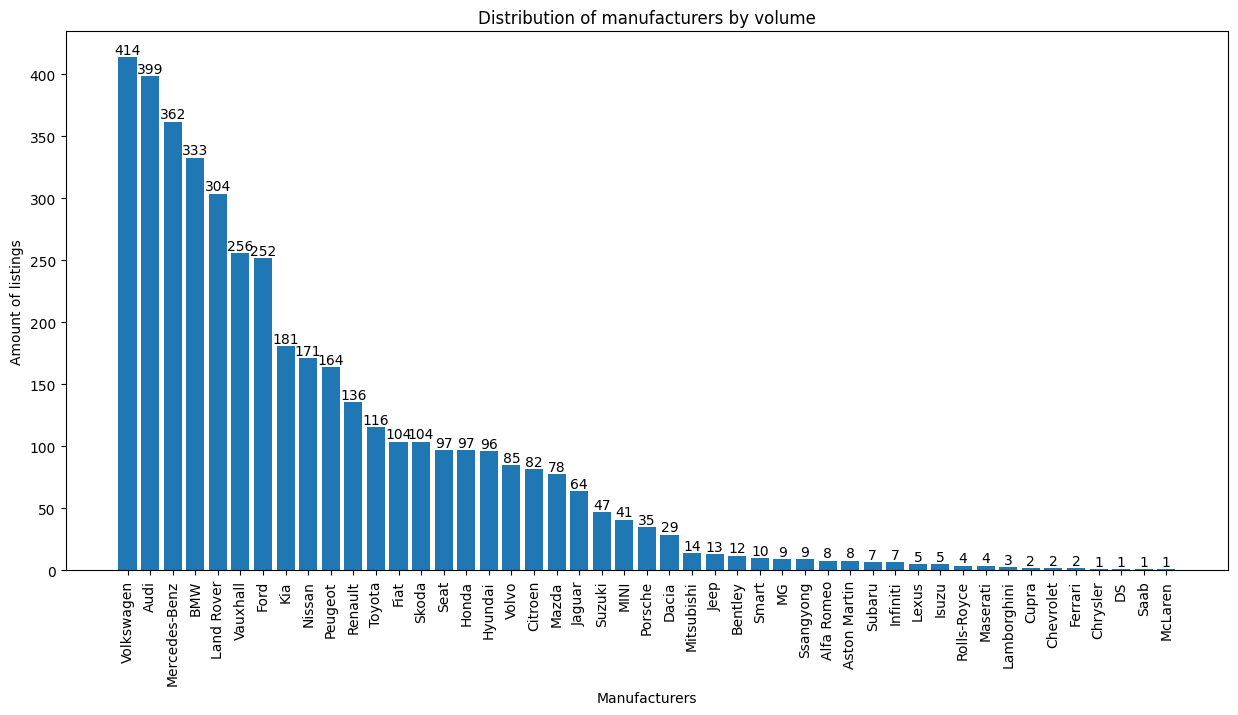

In [4]:
manufacturer_bar_data = []
# finding the amount of each manufacturer from the database
my_query = """
SELECT manufacturer_name, COUNT(*) as count
FROM (
    SELECT dataset.manufacturer_id, manufacturers.manufacturer_name
    FROM dataset
    LEFT JOIN manufacturers ON dataset.manufacturer_id = manufacturers.manufacturer_id
) AS joined_data
GROUP BY manufacturer_name
ORDER BY count DESC;
"""
mycursor.execute(my_query)
results = mycursor.fetchall()
for row in results:
    manufacturer_bar_data.append(row)

# splitting the manufacturer_ids from their respective counts
manufacturer_names = np.array([entry['manufacturer_name'] for entry in manufacturer_bar_data])
counts = np.array([entry['count'] for entry in manufacturer_bar_data])

# plotting the bar chart
plt.figure(figsize=(15,7))
bars = plt.bar(manufacturer_names, counts)
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')
plt.title("Distribution of manufacturers by volume")
plt.xlabel("Manufacturers"), plt.ylabel("Amount of listings"), plt.xticks(rotation=90)
plt.show()

# Model Occurrences

Similarly to the previous graph. This bar chart will help visualise which models of cars are the most prevalent.

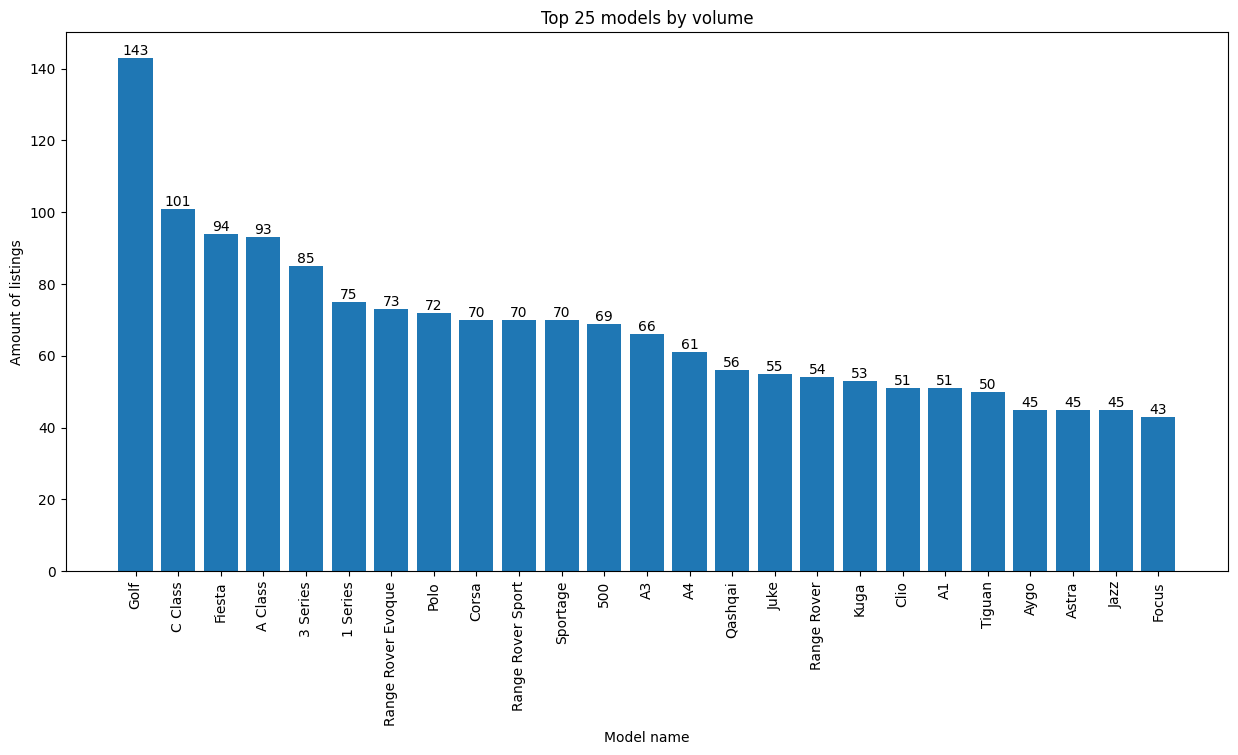

In [5]:
model_bar_data = []
# finding the top 25 models by amount from the database
my_query = """
SELECT model_name, COUNT(*) as count
FROM (
    SELECT dataset.model_id, models.model_name
    FROM dataset
    LEFT JOIN models ON dataset.model_id = models.model_id
) AS joined_data
GROUP BY model_name
ORDER BY count DESC
LIMIT 25;
"""
mycursor.execute(my_query)
results = mycursor.fetchall()
for row in results:
    model_bar_data.append(row)

# splitting the model_id from their respective counts
model_names = np.array([entry['model_name'] for entry in model_bar_data])
counts = np.array([entry['count'] for entry in model_bar_data])

# plotting the bar chart
plt.figure(figsize=(15,7))
bars = plt.bar(model_names, counts)
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')
plt.title("Top 25 models by volume")
plt.xlabel("Model name"), plt.ylabel("Amount of listings")
plt.xticks(rotation=90)
plt.show() 

In [6]:
# distribution of fuel types for each manufacturer
# work in progress

fuel_type_query = """
SELECT m.manufacturer_name, f.fuel_type, 
       count(*) as occurrences
       FROM webscraper.dataset d
			INNER JOIN manufacturers m ON m.manufacturer_id = d.manufacturer_id
			INNER JOIN fuel_types f ON f.fuel_id = d.fuel_type_id
group by d.manufacturer_id, fuel_type_id
order by manufacturer_name ASC, fuel_type ASC;
"""

mycursor.execute(fuel_type_query)
results = mycursor.fetchall()

# using the pd.read_sql function we can get queries directly into dataframes
result_dataframe = pd.read_sql(fuel_type_query, mydb)
#print(result_dataframe)


manufacturer_fuel_data = {}
for manufacturer in manufacturer_names:
    manufacturer_fuel_data[manufacturer] = {}    
for entry in results:
    manufacturer = entry['manufacturer_name']
    fuel_type = entry['fuel_type']
    occurrences = entry['occurrences']

    if fuel_type not in manufacturer_fuel_data[manufacturer]:
        manufacturer_fuel_data[manufacturer][fuel_type] = occurrences
    else:
        manufacturer_fuel_data[manufacturer][fuel_type] += occurrences
    
df = pd.DataFrame.from_dict(manufacturer_fuel_data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'manufacturer'}, inplace=True)
df.fillna(0, inplace=True)

my_manufacturer_list = []
my_diesel_list = []
my_hybrid_list = []
my_petrol_list = []

# ax = df.plot(x='manufacturer', kind='bar', figsize=(15, 7), stacked=True, rot=90)
# ax.set_xlabel('Manufacturers')
# ax.set_ylabel('Occurrences')


# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, weight='bold')
#     
# plt.show()

# Analysis the affect of mileage on price for the top 25 models

This will help visualise how mileage affects different models' prices.

We can also find which models lose value the fastest on average (assuming linearity).

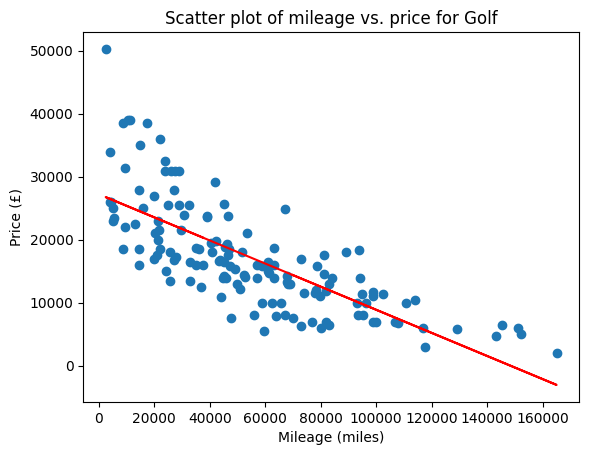

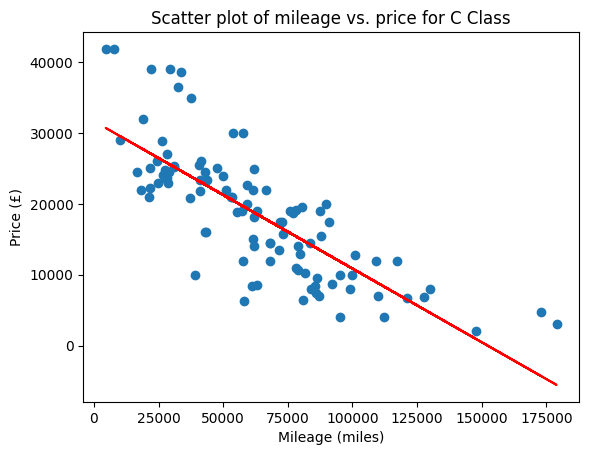

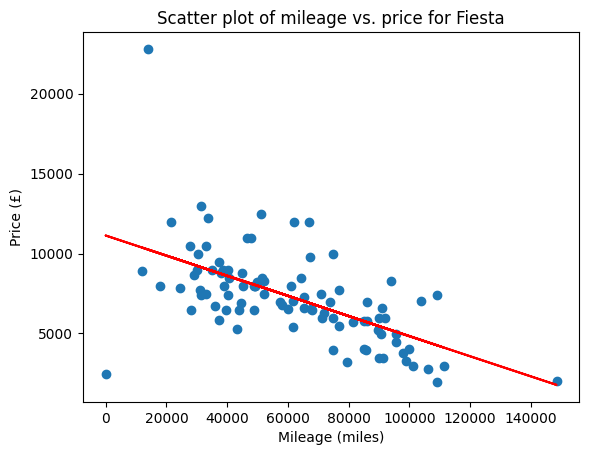

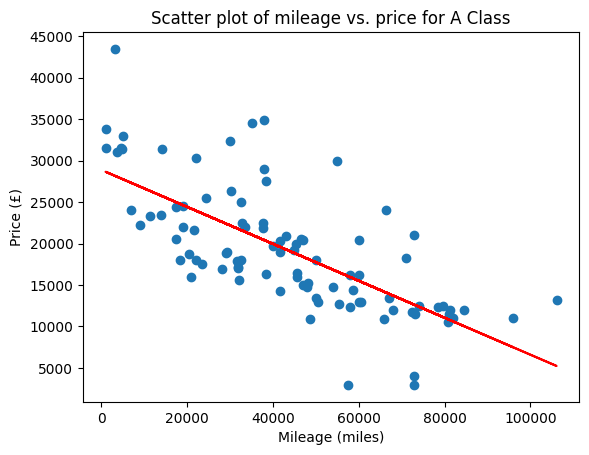

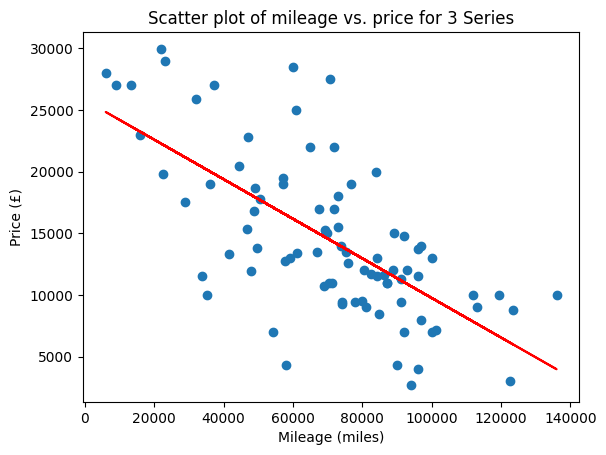

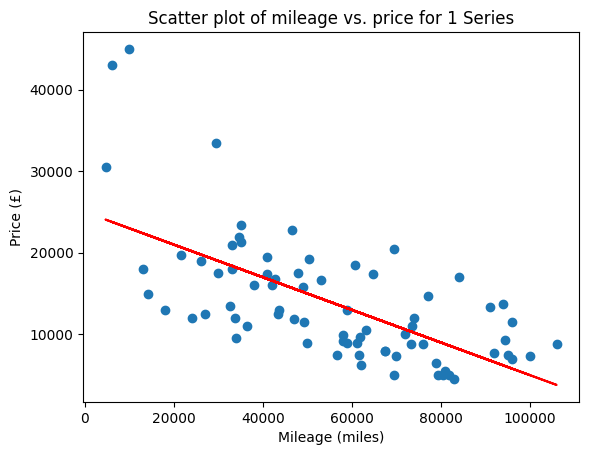

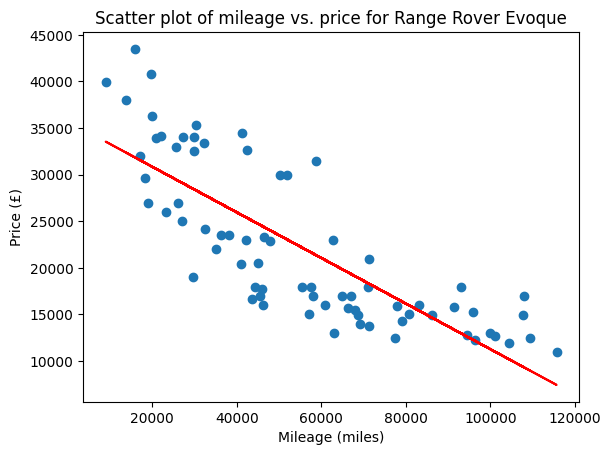

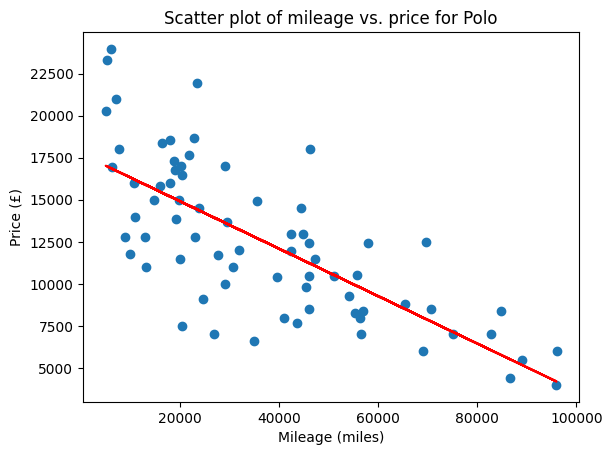

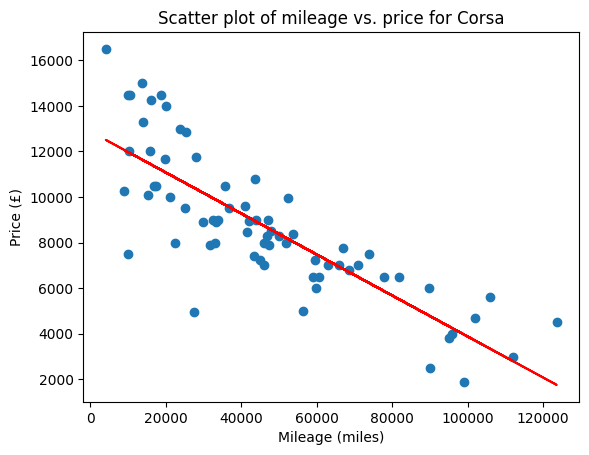

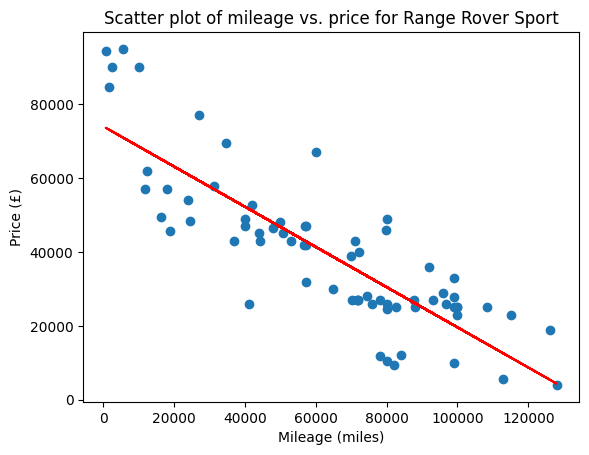

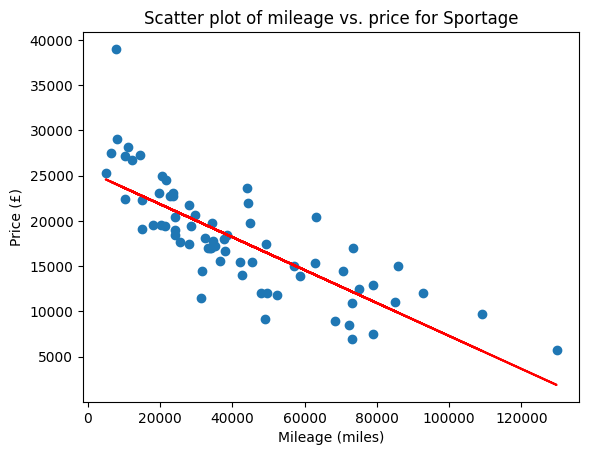

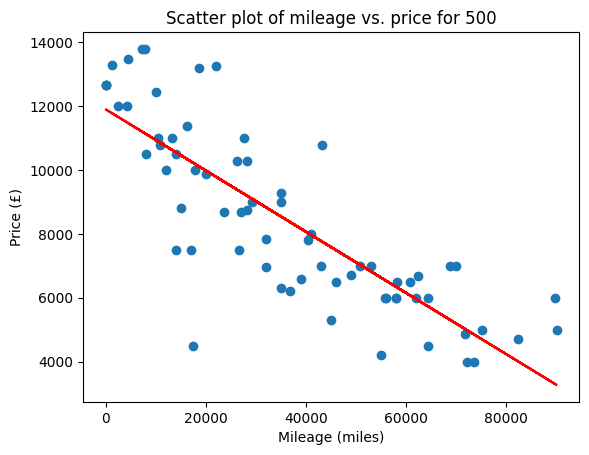

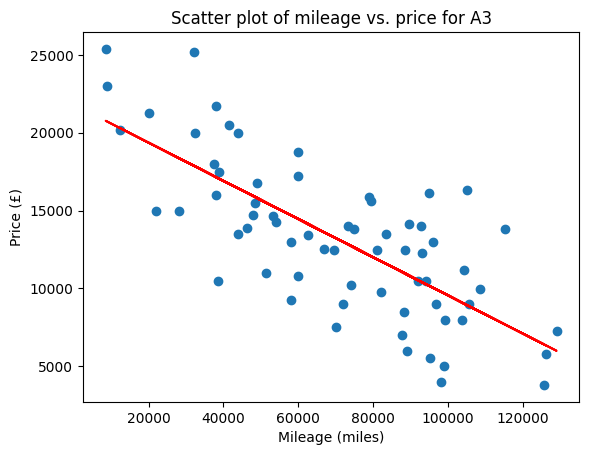

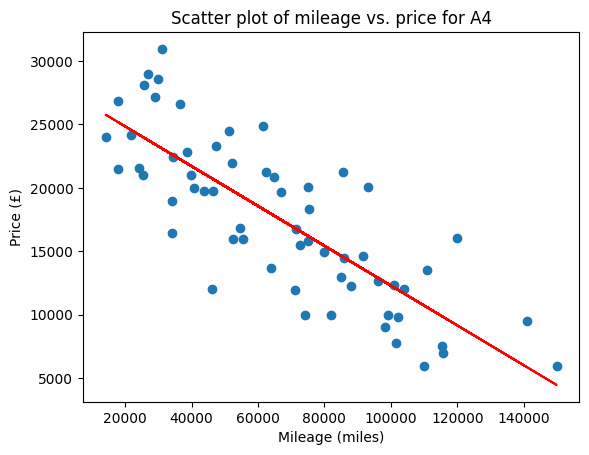

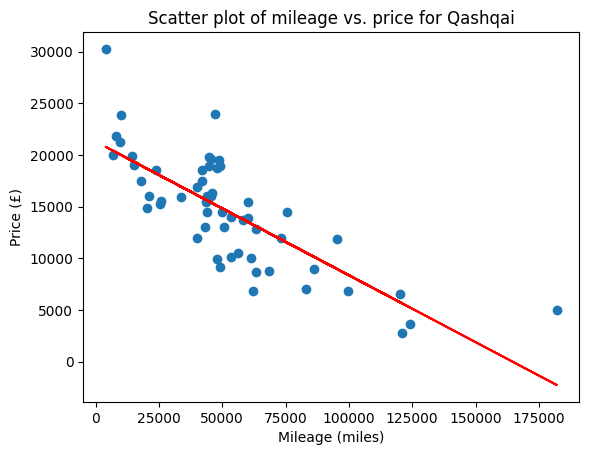

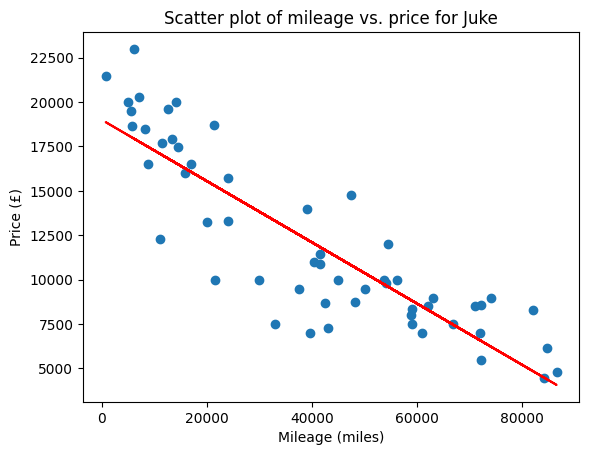

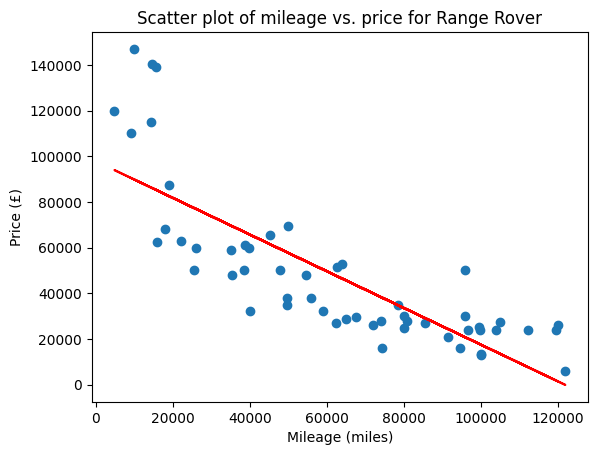

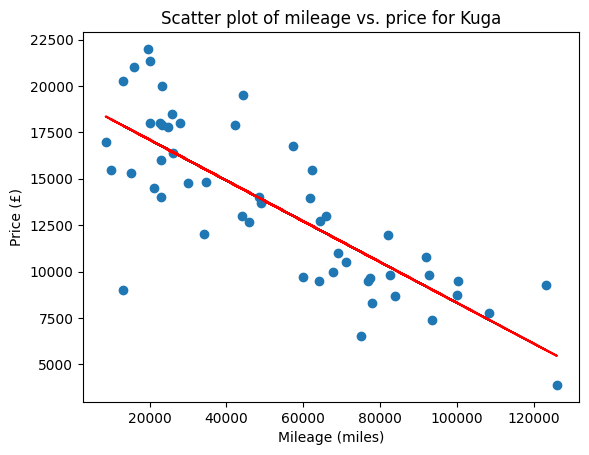

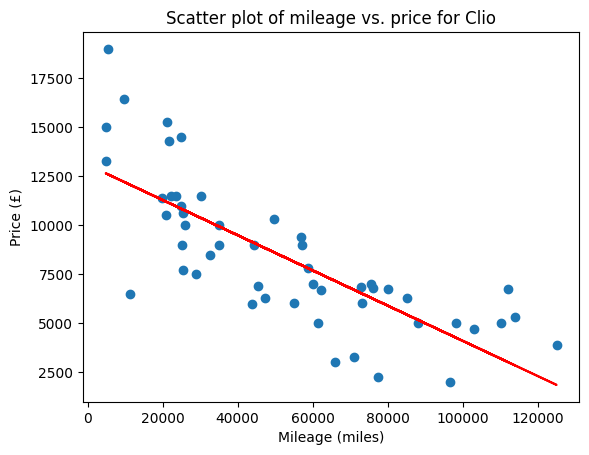

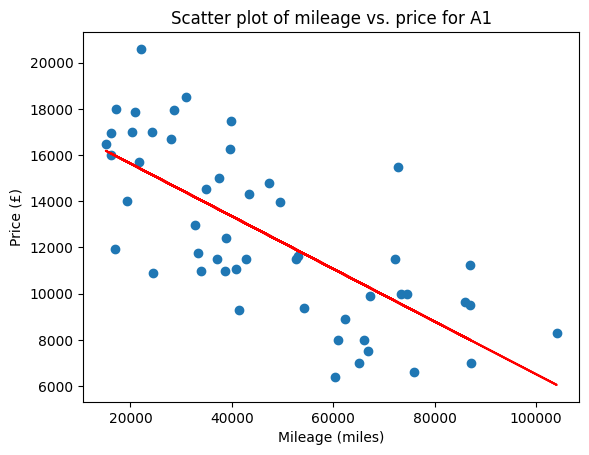

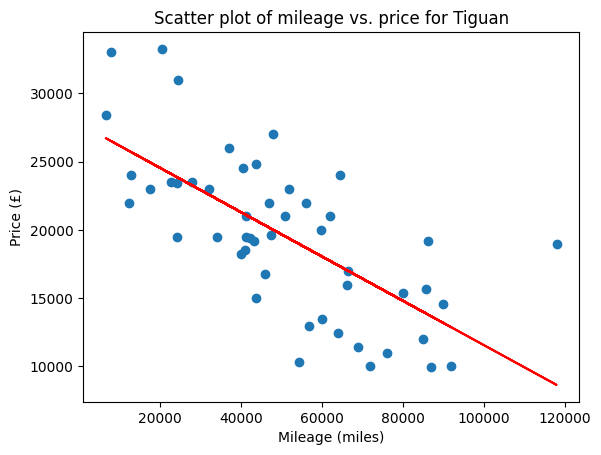

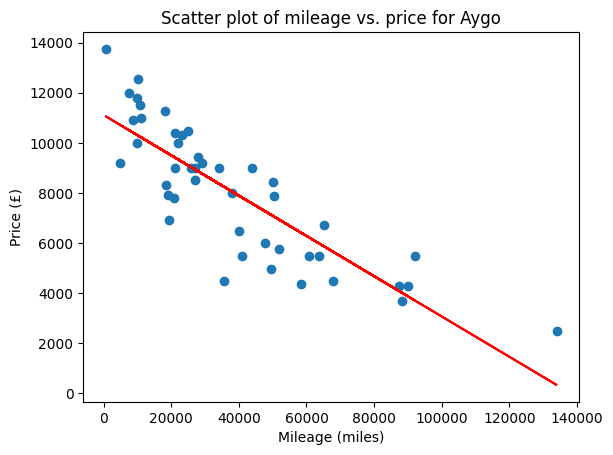

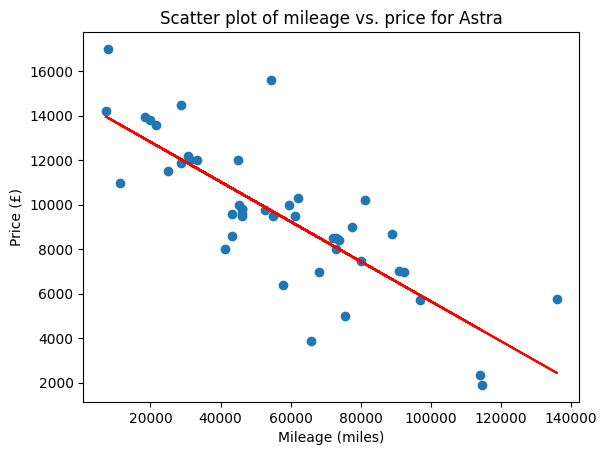

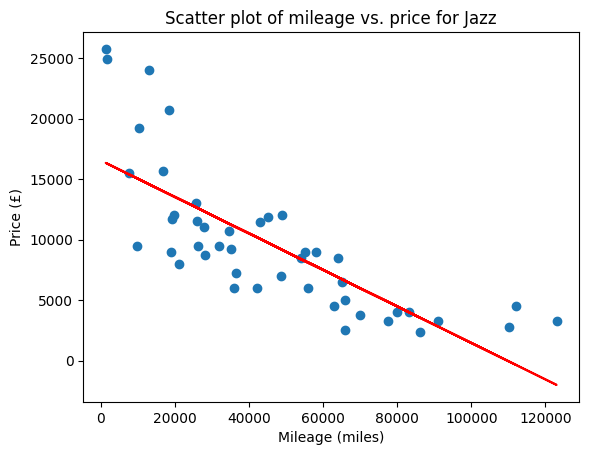

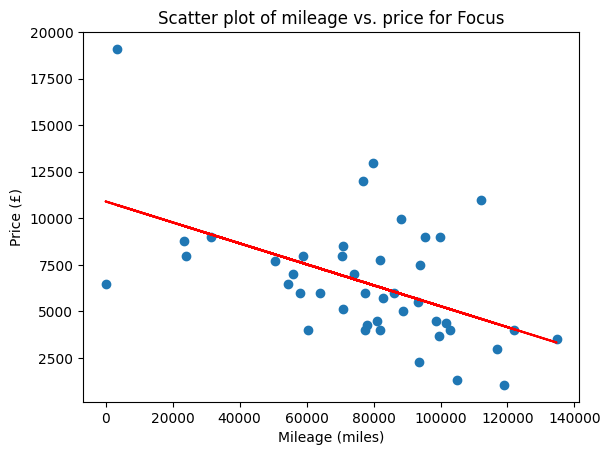

          manufacturer      rate
0          Range Rover -0.802923
1    Range Rover Sport -0.543727
2   Range Rover Evoque -0.244671
3              A Class -0.222771
4              C Class -0.207774
5             1 Series -0.199995
6                 Golf -0.183437
7             Sportage -0.181957
8                 Juke -0.172514
9               Tiguan -0.162248
10            3 Series -0.160467
11                  A4 -0.156852
12                Jazz -0.150698
13                Polo -0.140959
14             Qashqai -0.129379
15                  A3 -0.122747
16                  A1 -0.113983
17                Kuga -0.109811
18                 500 -0.095887
19                Clio -0.089982
20               Corsa -0.089947
21               Astra -0.089426
22                Aygo -0.080415
23              Fiesta -0.062880
24               Focus -0.056270


In [7]:
# scatter plots and rate analysis for the top 25 models:

query = "SELECT model_id, COUNT(*) as count FROM dataset GROUP BY model_id ORDER BY count DESC LIMIT 25"
results = pd.read_sql(query, mydb)
models = list(results['model_id'])

rates = []

for i in range(len(models)):
    query = f"SELECT * FROM dataset WHERE model_id = {models[i]}"
    results = pd.read_sql(query, mydb)
    
    x = results['Mileage (miles)']
    y = results['price']
    
    coefficients = np.polyfit(x, y, 1)
    
    plt.scatter(x, y)
    plt.title(f"Scatter plot of mileage vs. price for {model_bar_data[i]['model_name']}")
    plt.xlabel("Mileage (miles)"), plt.ylabel("Price (£)")
    
    x_array = np.array(x)
    
    plt.plot(x, coefficients[0] * x_array + coefficients[1], color='r')
    
    plt.show()

    rate = (coefficients[0])
    rates.append(rate)


# dataframe of ascending rates of depreciation with mileage
rates_data = {'manufacturer': [entry['model_name'] for entry in model_bar_data], 'rate': rates}
rates_dataframe = pd.DataFrame(rates_data)
rates_dataframe = rates_dataframe.sort_values(by='rate', ascending=True)
rates_dataframe.reset_index(drop=True, inplace=True)
print(rates_dataframe)

# Analysis of how mileage affects price for petrol and diesel VW Golfs

Using scatter plots we can visualise how mileage affects price.
Moreover, we can use the trendlines produced to inspect the how the different fuel type changes the value of the car as mileage increases.

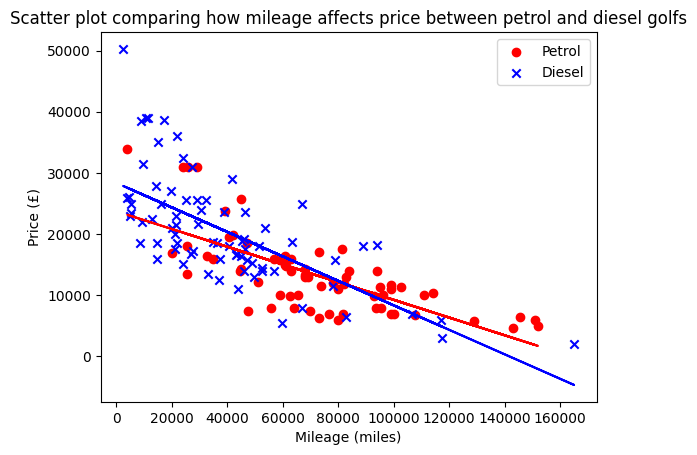

In [8]:
# petrol vs diesel golfs

query = "SELECT * FROM dataset WHERE model_id = 5 AND fuel_type_id = 2"
results_set1 = pd.read_sql(query, mydb)

x_set1 = results_set1['Mileage (miles)']
y_set1 = results_set1['price']

query = "SELECT * FROM dataset WHERE model_id = 5 and fuel_type_id = 1"
results_set2 = pd.read_sql(query, mydb)

x_set2 = results_set2['Mileage (miles)']
y_set2 = results_set2['price']

fig, ax = plt.subplots()

ax.scatter(x_set1, y_set1, label='Petrol', color='r', marker='o')
ax.scatter(x_set2, y_set2, label='Diesel', color='b', marker='x')

coefficients_set1 = np.polyfit(x_set1, y_set1, 1)
coefficients_set2 = np.polyfit(x_set2, y_set2, 1)

x_set1_array = np.array(x_set1)
x_set2_array = np.array(x_set2)

ax.plot(x_set1, coefficients_set1[0] * x_set1_array + coefficients_set1[1], color='r')
ax.plot(x_set2, coefficients_set2[0] * x_set2_array + coefficients_set2[1], color='b')

ax.legend()
ax.set_title("Scatter plot comparing how mileage affects price between petrol and diesel golfs")
ax.set_xlabel("Mileage (miles)"), ax.set_ylabel("Price (£)")

plt.show()

# Analysis of how mileage affects the price of manual and automatic VW Golfs

Similarly to the chunk above. We will visualise how the difference in transmission can affect the car's value as mileage increases.
We can then use the trendlines to difference in rates.

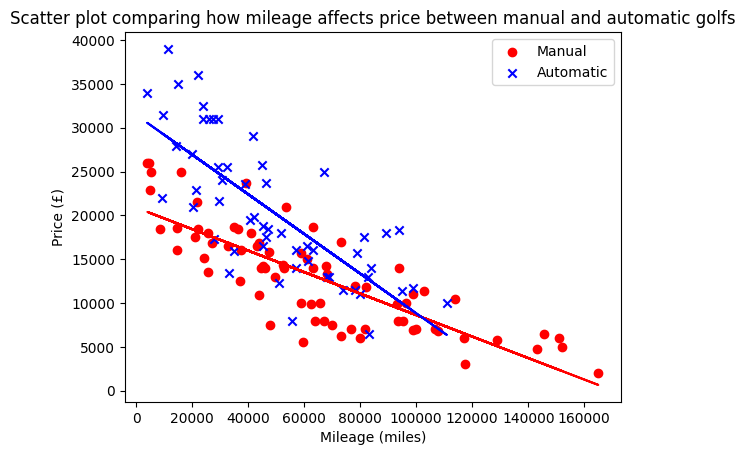

In [9]:
# manual vs automatic golfs
query = "SELECT * FROM dataset WHERE model_id = 5 and transmission_type_id = 2"
results_set1 = pd.read_sql(query, mydb)

x_set1 = results_set1['Mileage (miles)']
y_set1 = results_set1['price']

query = "SELECT * FROM dataset WHERE model_id = 5 and transmission_type_id = 3"
results_set2 = pd.read_sql(query, mydb)

x_set2 = results_set2['Mileage (miles)']
y_set2 = results_set2['price']

fig, ax = plt.subplots()

ax.scatter(x_set1, y_set1, label='Manual', color='red', marker='o')

ax.scatter(x_set2, y_set2, label='Automatic', color='blue', marker='x')

coefficients_set1 = np.polyfit(x_set1, y_set1, 1)

x_set1_array = np.array(x_set1)

ax.plot(x_set1, coefficients_set1[0] * x_set1_array + coefficients_set1[1], color='r')

coefficients_set2 = np.polyfit(x_set2, y_set2, 1)

x_set2_array = np.array(x_set2)

ax.plot(x_set2, coefficients_set2[0] * x_set2_array + coefficients_set2[1], color='b')
ax.set_title("Scatter plot comparing how mileage affects price between manual and automatic golfs")
ax.set_xlabel("Mileage (miles)"), ax.set_ylabel("Price (£)")
ax.legend()

plt.show()

# Investigating which models are listed with the highest average mileage

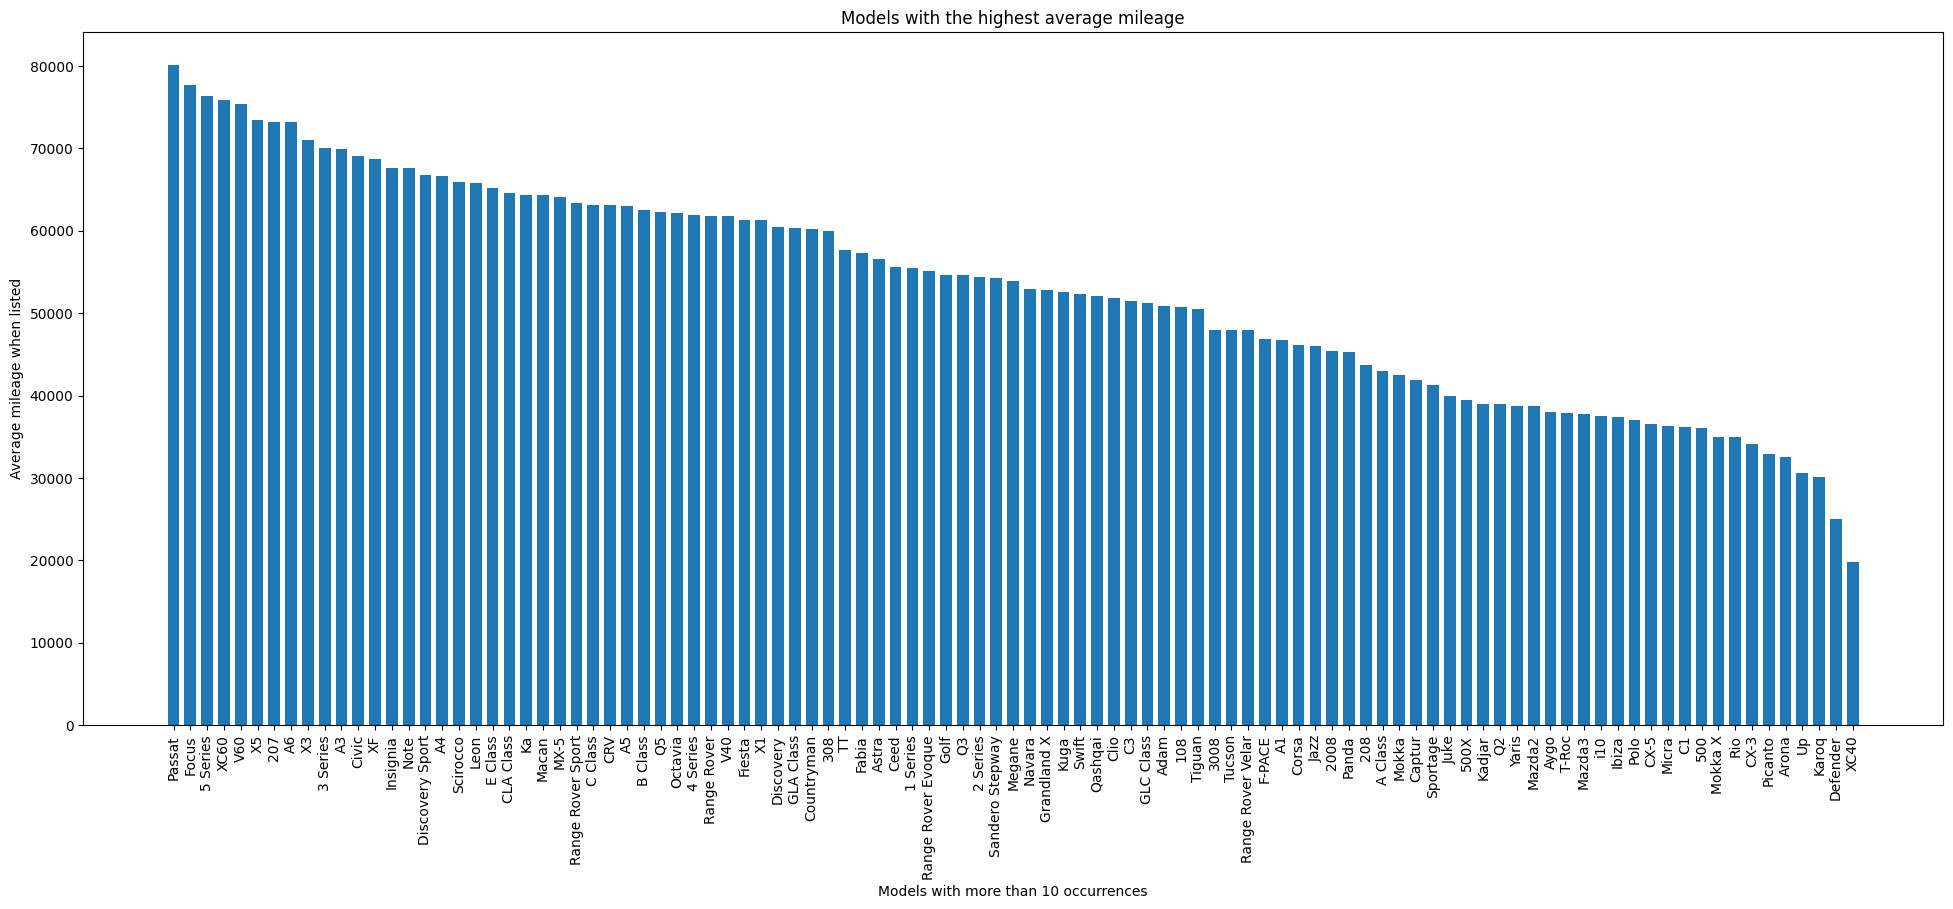

In [10]:
query = """
SELECT m.model_name,
       count(*) as occurrences,
       ROUND(avg(d.`mileage (miles)`)) AS Average, MAX(d.`mileage (miles)`) AS Max
	FROM webscraper.dataset d
			INNER JOIN models m ON m.model_id = d.model_id
group by d.model_id
HAVING occurrences > 10
ORDER BY avg(d.`mileage (miles)`) DESC
"""

results = pd.read_sql(query, mydb)

x = results['model_name']
y = results['Average']

plt.figure(figsize=(24, 9))
plt.bar(x, y, width=0.7)
plt.xlabel('Models with more than 10 occurrences'), plt.ylabel('Average mileage when listed')
plt.xticks(rotation=90)
plt.title("Models with the highest average mileage")

plt.show()

# Investigating which manufacturers are listed with the highest average mileage

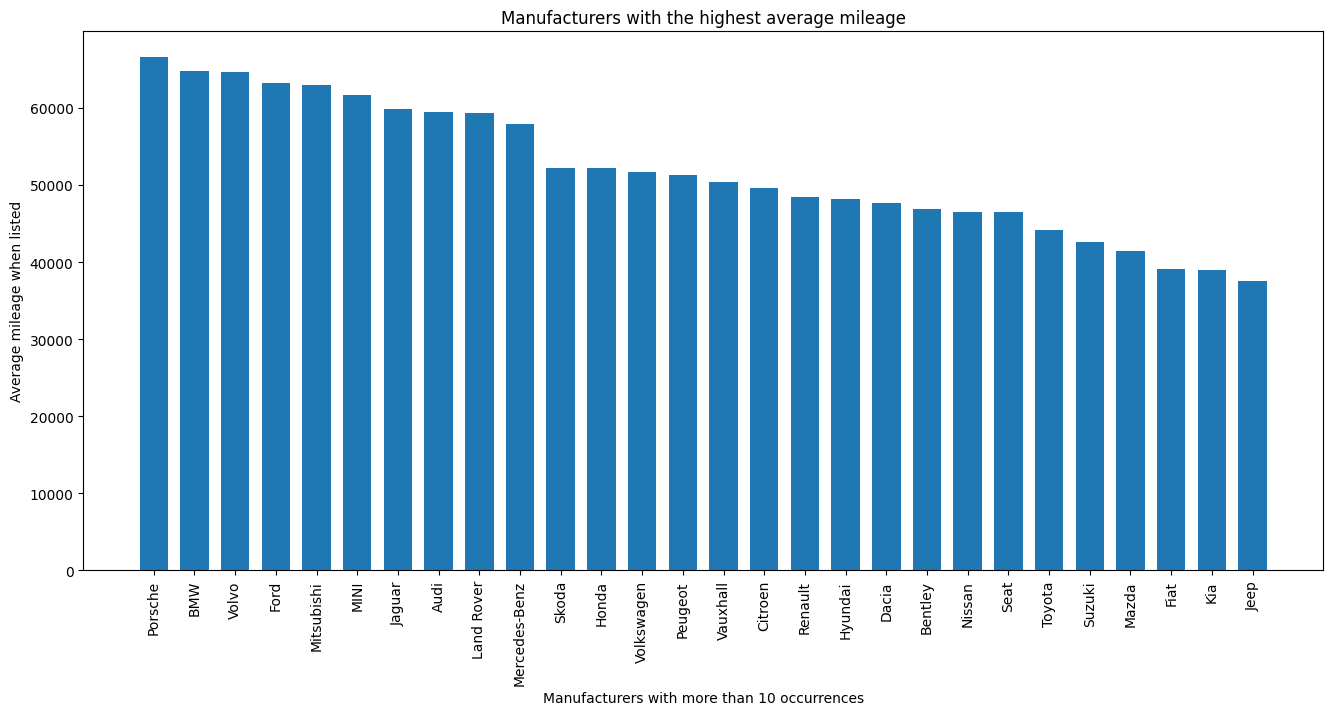

In [11]:
query = """
SELECT m.manufacturer_name,
		count(*) as occurrences,
        ROUND(avg(d.`mileage (miles)`)) AS Average, MAX(d.`mileage (miles)`) AS Max
	FROM webscraper.dataset d
			INNER JOIN manufacturers m ON m.manufacturer_id = d.manufacturer_id
Group BY d.manufacturer_id
HAVING occurrences > 10
ORDER BY AVG(d.`mileage (miles)`) DESC;

"""

results = pd.read_sql(query, mydb)

x = results['manufacturer_name']
y = results['Average']

plt.figure(figsize=(16, 7))
plt.bar(x, y, width=0.7)
plt.xlabel('Manufacturers with more than 10 occurrences'), plt.ylabel('Average mileage when listed')
plt.xticks(rotation=90)
plt.title("Manufacturers with the highest average mileage")

plt.show()

# Looking at the average price and mileage for each colour car

    Colour  occurrences  Average price  Max price  Average mileage  \
0    Other           13        21622.0      46499          15874.0   
1    Green           27        20055.0     114995          47127.0   
2   Orange           26        18929.0      55455          34101.0   
3     Grey          653        18658.0     209995          53783.0   
4    Black          941        17977.0     239999          56893.0   
5    White          698        17090.0     209991          48298.0   
6     Gold           12        16201.0      36959          62943.0   
7     Blue          579        15177.0     178995          56437.0   
8   Silver          522        13940.0      62995          59403.0   
9      Red          478        12725.0     165000          50798.0   
10   Brown           23        11217.0      20990          54456.0   
11  Yellow           20        10150.0      29988          51052.0   
12  Purple           12         7922.0      17290          61815.0   
13   Beige          

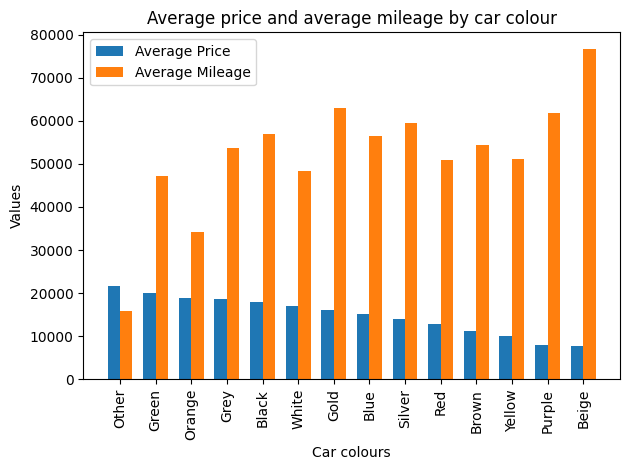

    Colour  occurrences  Average price  Max price  Average mileage  \
0    Other           13        21622.0      46499          15874.0   
1   Orange           26        18929.0      55455          34101.0   
2    Green           27        20055.0     114995          47127.0   
3    White          698        17090.0     209991          48298.0   
4     Grey          653        18658.0     209995          53783.0   
5    Black          941        17977.0     239999          56893.0   
6     Blue          579        15177.0     178995          56437.0   
7     Gold           12        16201.0      36959          62943.0   
8      Red          478        12725.0     165000          50798.0   
9   Silver          522        13940.0      62995          59403.0   
10   Brown           23        11217.0      20990          54456.0   
11  Yellow           20        10150.0      29988          51052.0   
12  Purple           12         7922.0      17290          61815.0   
13   Beige          

In [12]:
query = """
SELECT Colour,
		COUNT(*) as occurrences,
        round(avg(d.price)) AS `Average price`, max(d.price) AS `Max price`, round(avg(d.`mileage (miles)`)) AS `Average mileage`,
        avg(d.price) / avg(d.`mileage (miles)`) AS `Average price per mile`
	FROM webscraper.dataset d
GROUP BY d.Colour
HAVING occurrences > 10
ORDER BY AVG(d.price) DESC;
"""

results = pd.read_sql(query, mydb)
print(results)

colour = results['Colour']
average_price = results['Average price']
average_mileage = results['Average mileage']

bar_width = 0.35
x = np.arange(len(colour))

fig, ax = plt.subplots()

bar1 = ax.bar(x - bar_width/2, average_price, bar_width, label='Average Price')
bar2 = ax.bar(x + bar_width/2, average_mileage, bar_width, label='Average Mileage')

ax.set_xticks(x)
ax.set_xticklabels(colour)
ax.set_xlabel('Car colours')
ax.set_ylabel('Values')
ax.set_title('Average price and average mileage by car colour')
plt.xticks(rotation=90)

ax.legend()
plt.tight_layout()
plt.show()

query = """
SELECT Colour,
		COUNT(*) as occurrences,
        round(avg(d.price)) AS `Average price`, max(d.price) AS `Max price`, round(avg(d.`mileage (miles)`)) AS `Average mileage`,
        avg(d.price) / avg(d.`mileage (miles)`) AS `Average price per mile`
	FROM webscraper.dataset d
GROUP BY d.Colour
HAVING occurrences > 10
ORDER BY `Average price per mile` DESC;
"""

ordered_by_price_per_mile = pd.read_sql(query, mydb)

print(ordered_by_price_per_mile)

# Exploring whether the colour of the car affects the rate at which mileage causes depreciation

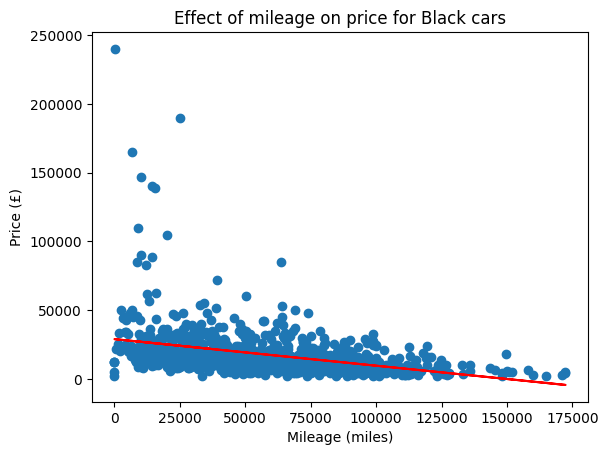

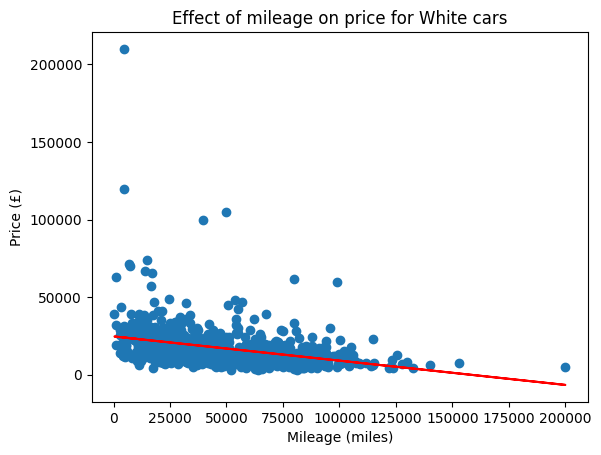

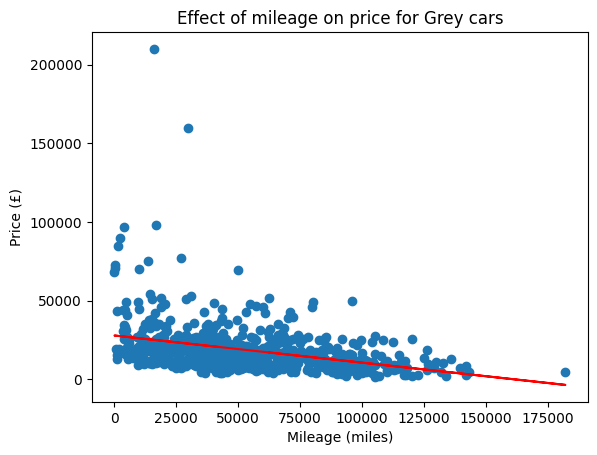

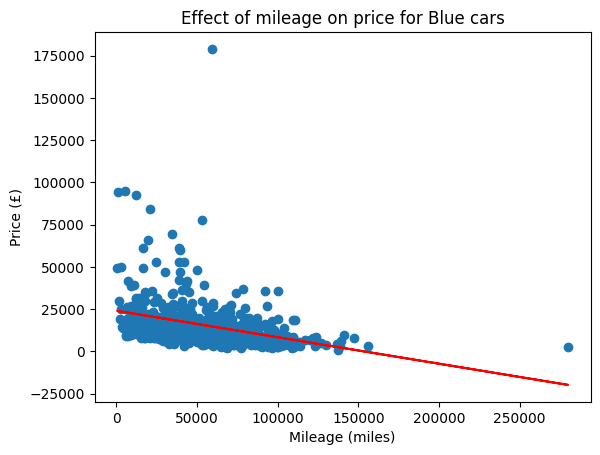

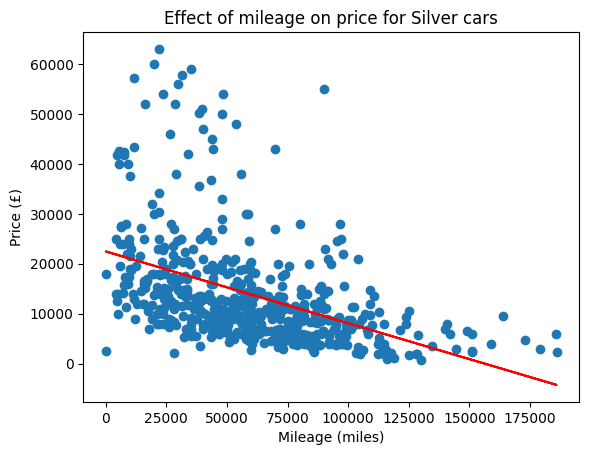

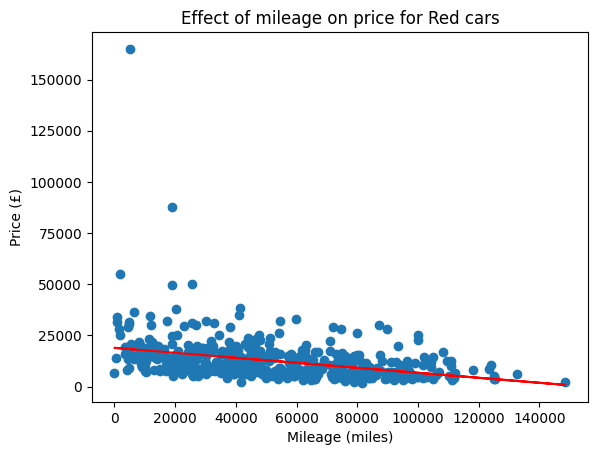

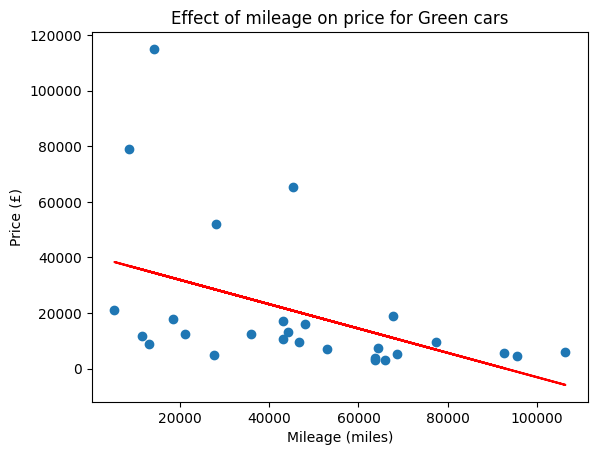

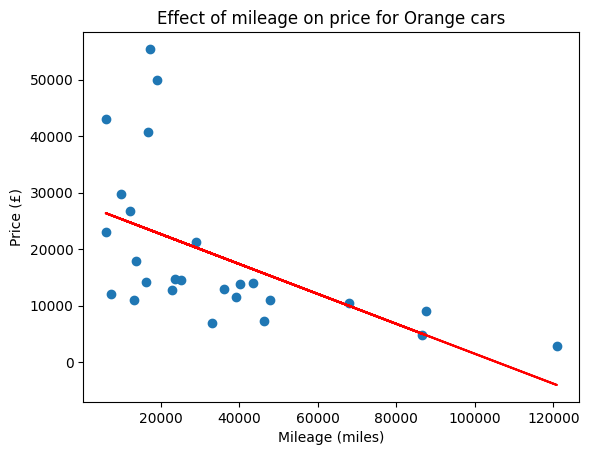

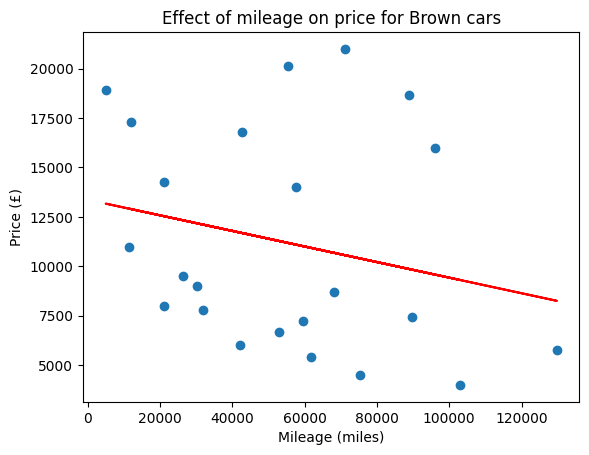

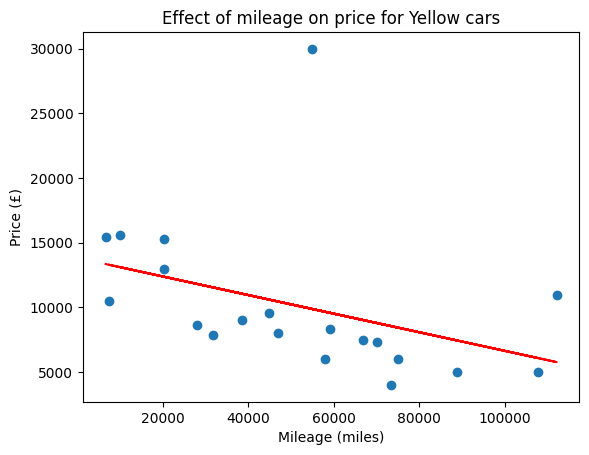

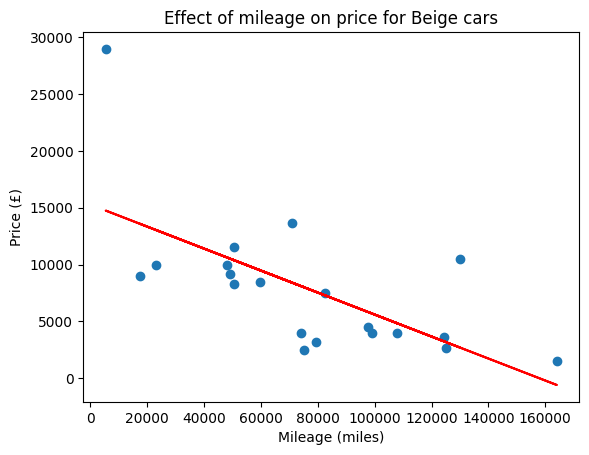

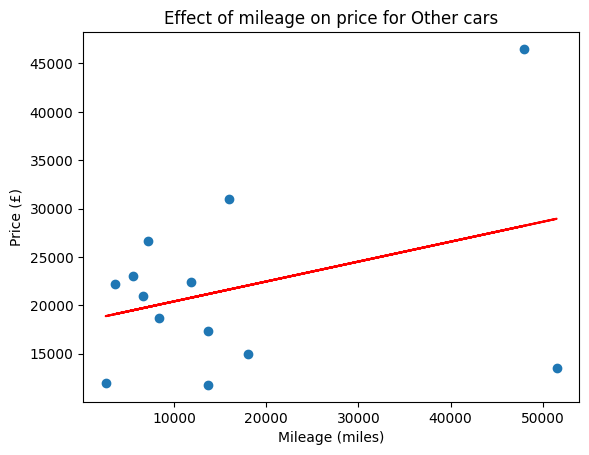

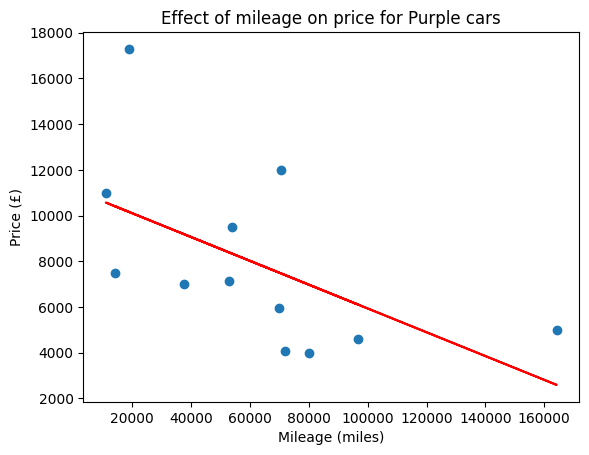

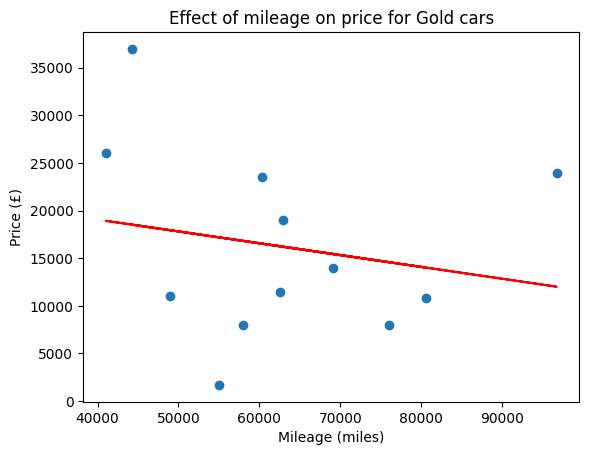

    Colour  depreciation
0    Green     -0.436916
1   Orange     -0.264812
2    Black     -0.193261
3     Grey     -0.172471
4     Blue     -0.156800
5    White     -0.156432
6   Silver     -0.143615
7     Gold     -0.124019
8      Red     -0.122085
9    Beige     -0.096833
10  Yellow     -0.071830
11  Purple     -0.052061
12   Brown     -0.039378
13   Other      0.205571


In [13]:
query = "SELECT Colour, COUNT(*) as occurrences FROM dataset GROUP BY Colour HAVING occurrences > 10 ORDER BY occurrences DESC;"
results = pd.read_sql(query, mydb)

results_colours = np.array(results['Colour'])

depreciation_list = []

for colour in results_colours:
    query = f"SELECT * FROM dataset WHERE Colour = '{colour}'"
    results = pd.read_sql(query, mydb)
    x = results['Mileage (miles)']
    y = results['price']
    
    coefficients = np.polyfit(x, y, 1)
    x_array = np.array(x)
    plt.scatter(x, y)
    plt.plot(x, coefficients[0] * x_array + coefficients[1], color='r')
    plt.xlabel("Mileage (miles)"), plt.ylabel("Price (£)")
    plt.title(f"Effect of mileage on price for {colour} cars")
    depreciation_list.append(coefficients[0])
    plt.show()
    
depreciation_data_by_colour = {'Colour': [colour for colour in results_colours], 'depreciation': depreciation_list}
depreciation_rate_dataframe = pd.DataFrame(depreciation_data_by_colour)
depreciation_rate_dataframe = depreciation_rate_dataframe.sort_values(by='depreciation', ascending=True)
depreciation_rate_dataframe.reset_index(drop=True, inplace=True)

print(depreciation_rate_dataframe)